## Panel 3 — Looking Ahead: Prevention & Prediction

**Goal:** Forecast Hawaii's firearm deaths for the next 3 years using an interpretable, lightweight model and summarize prevention-focused recommendations.

**Why this matters:** A transparent forecast helps city and state leaders plan resource allocation (e.g., mental-health services, safe storage outreach) and evaluate whether Hawaii's trajectory is improving or worsening.

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
DATA_DIR = Path('/Users/johnnybae/Documents/Academia/Chaminade/DS495 - Research')

inc = pd.read_csv(DATA_DIR/'Incidents/incidents_all_years.csv.gz', na_values=['N/A'], low_memory=False)
parts = pd.read_csv(DATA_DIR/'Participants/participants_all_years.csv.gz', na_values=['N/A'], low_memory=False)

### Build incident-level table with `State` and `Year`

We avoid a heavy row-wise merge by creating a tiny **ID → (State, Year)** map from participants, then merging once onto incidents.

In [10]:
# Keep only the participant columns we need to tag each incident
need = [c for c in ['ID','State','Date'] if c in parts.columns]
pt = parts[need].copy()

# Robust date parsing over common formats
dt = pd.to_datetime(pt['Date'], errors='coerce')
for fmt in ['%d-%b-%y','%Y-%m-%d','%m/%d/%Y','%m/%d/%y']:
    mask = dt.isna()
    if not mask.any():
        break
    dt.loc[mask] = pd.to_datetime(pt.loc[mask,'Date'], format=fmt, errors='coerce')

pt['Year'] = pd.to_numeric(dt.dt.year, errors='coerce')

def first_mode(s: pd.Series):
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else pd.NA

id_map = (
    pt.groupby('ID', as_index=False)
    .agg(
        State=('State', first_mode),
        Year =('Year',  'max')
        )
)

for c in ['Vic-Killed','Vic-Injured','Sus-Killed','Sus-Injured','Sus-Unharmed','Sus-Arrested']:
    if c in inc.columns:
        inc[c] = pd.to_numeric(inc[c], errors='coerce')

incidents_enriched = inc.merge(id_map, on='ID', how='left').dropna(subset=['Year'])

print('incidents_enriched shape:', incidents_enriched.shape)
incidents_enriched[['ID','State','Year']].head()

/var/folders/vg/b0s2p58n6p14svh9j4syj9r00000gn/T/ipykernel_10798/1076007230.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(pt['Date'], errors='coerce')


incidents_enriched shape: (428678, 11)


,ID,State,Year
0,3040722.0,California,2014.0
1,3040717.0,California,2014.0
2,291511.0,Virginia,2014.0
3,278757.0,Mississippi,2014.0
4,277950.0,Virginia,2014.0


### Aggregate Hawaii yearly totals

We compute total firearm deaths (`Vic-Killed`) per year for Hawaii from 2014–2024.

In [11]:
hi_yearly = (incidents_enriched[incidents_enriched['State']=='Hawaii']
              .groupby('Year', dropna=True)
              .agg(killed=('Vic-Killed','sum'))
              .reset_index()
              .sort_values('Year'))

hi_yearly.tail()

,Year,killed
6,2020.0,15.0
7,2021.0,14.0
8,2022.0,15.0
9,2023.0,19.0
10,2024.0,16.0


### Model: Simple Linear Regression

We fit a **straight line** to historical data using NumPy’s `polyfit` (degree=1)
This is equivalent to linear regression and is a **supervised learning** model for a continuous target

**Model form:**  
$\text{Deaths} = m \times \text{Year} + b$

- `m` = slope (change in deaths per year)  
- `b` = intercept (baseline)

**Why Linear Regression?**  
It’s fast, transparent, and easy to explain. It provides a reasonable short term projection when the historical trend is roughly linear.

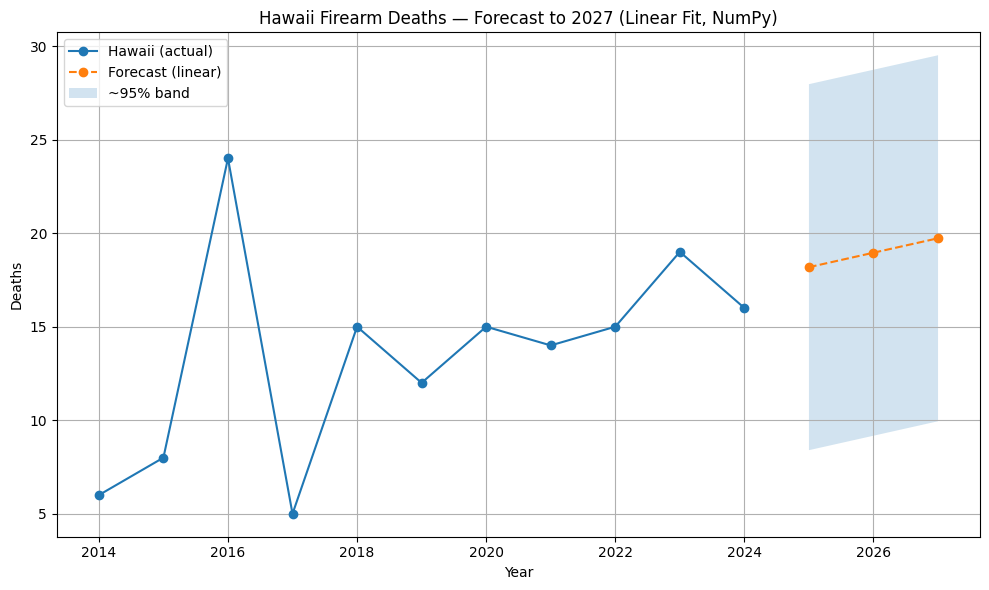

In [12]:
hi_yearly['Year'] = pd.to_numeric(hi_yearly['Year'], errors='coerce')
hi_yearly['killed'] = pd.to_numeric(hi_yearly['killed'], errors='coerce')
hi_yearly = hi_yearly.dropna()

x = hi_yearly['Year'].values.astype(float)
y = hi_yearly['killed'].values.astype(float)

if len(x) >= 2:
    # --- ML training step (learning m and b) ---
    m, b = np.polyfit(x, y, deg=1)  # <-- This line does the "learning"

    # Predictions for future years
    future = np.array([2025, 2026, 2027], dtype=float)
    yhat_hist   = m*x + b
    yhat_future = m*future + b

    # Approx. 95% uncertainty band via residual std dev
    resid = y - yhat_hist
    sigma = resid.std(ddof=1) if len(resid) > 1 else 0.0
    lower = yhat_future - 1.96*sigma
    upper = yhat_future + 1.96*sigma
else:
    future = np.array([2025, 2026, 2027], dtype=float)
    yhat_future = np.array([np.nan, np.nan, np.nan])
    lower = upper = yhat_future
    sigma = np.nan

plt.figure(figsize=(10,6))
plt.plot(x, y, marker='o', label='Hawaii (actual)')
plt.plot(future, yhat_future, marker='o', linestyle='--', label='Forecast (linear)')
if np.isfinite(lower).all():
    plt.fill_between(future, lower, upper, alpha=0.2, label='~95% band')
plt.title('Hawaii Firearm Deaths — Forecast to 2027 (Linear Fit, NumPy)')
plt.xlabel('Year'); plt.ylabel('Deaths'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig('panel3_hi_linear.png', dpi=300)

plt.show()

### Model Parameters

In [21]:
hi_yearly = (
    incidents_enriched[incidents_enriched["State"] == "Hawaii"]
    .groupby("Year")["Vic-Killed"]
    .sum()
    .reset_index()
    .sort_values("Year")
)

# X = years, y = deaths
X = hi_yearly["Year"].values
y = hi_yearly["Vic-Killed"].values

# Fit line y = a*Year + b using numpy
a, b = np.polyfit(X, y, 1)
slope = a
intercept = b

print(f"Slope (β₁): {slope:.4f} deaths per year")
print(f"Intercept (β₀): {intercept:.4f}")


Slope (β₁): 0.7727 deaths per year
Intercept (β₀): -1546.5909


In [22]:
# Predict for future years
future_years = np.array([2025, 2026, 2027])
y_pred = slope * future_years + intercept
y_pred


array([18.18181818, 18.95454545, 19.72727273])

### Plot Explanation

- This is a **simple machine learning regression model** (linear regression) fit to historical Hawaiʻi data.
- The model predicts future deaths by plugging future years (2025-2027) into the learned line equation.
- The shaded band reflects **approximate 95% uncertainty**, based on past variability around the trend.
- **Limitations:** Assumes the past linear trend continues; it does not capture sudden policy changes, rare extreme events, or non-linear patterns.


### Data-Informed Recommendations

- Expand **mental health and suicide-prevention** programs (crisis lines, mobile response, school-based services).
- Encourage **safe storage** and community outreach partnerships.
- Improve **data sharing** across public health and law enforcement to target interventions and evaluate outcomes.

For Hawaiʻi, the data suggest an ongoing pattern of lower-count but persistent firearm incidents, rather than large, headline-grabbing spikes.